# **Assignment 3 - RRN - Weather Time Series Forcasting**

# **Name: Nisha Chaurasia**

# **Date: 11-04-2023**

**A temperature-forecasting example- Data Upload from mazon Web Services (AWS) /keras**

In [1]:
!pip install tensorflow==2.12

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-04 22:16:07--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.12.30, 54.231.234.136, 52.217.206.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.12.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  44.3MB/s    in 0.3s    

2023-11-04 22:16:08 (44.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

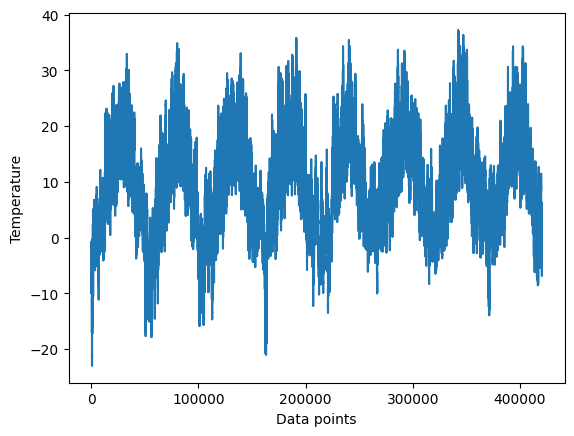

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points**

Text(0, 0.5, 'Temperature')

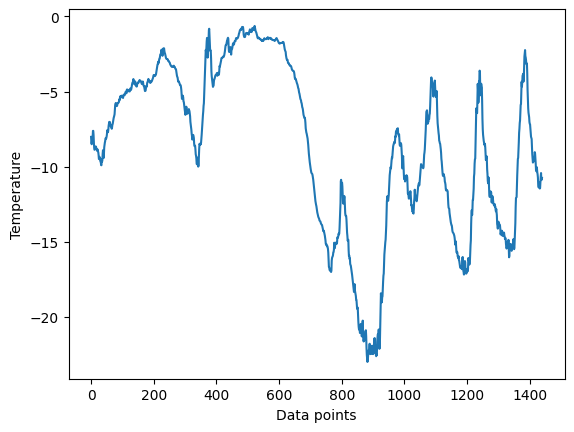

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.**

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. By using this straightforward baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [15]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 10s 11ms/step - loss: 12.0252 - mae: 2.6843 - val_loss: 10.3757 - val_mae: 2.5279
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 8.8058 - mae: 2.3362 - val_loss: 11.2280 - val_mae: 2.6445
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 8.1507 - mae: 2.2492 - val_loss: 10.3747 - val_mae: 2.5403
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 7.7056 - mae: 2.1888 - val_loss: 11.0939 - val_mae: 2.6264
Epoch 5/10
819/819 [==============================] - 11s 13ms/step - loss: 7.3838 - mae: 2.1456 - val_loss: 11.3492 - val_mae: 2.6629
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 7.1458 - mae: 2.1104 - val_loss: 10.7563 - val_mae: 2.5881
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 6.9704 - mae: 2.0864 - val_loss: 10.9957 - val_mae: 2.6113
Epoch 8/10
819/819 [==============================] - 1

In [17]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 8ms/step - loss: 11.1226 - mae: 2.6217
Test MAE: 2.62


**Plotting results**

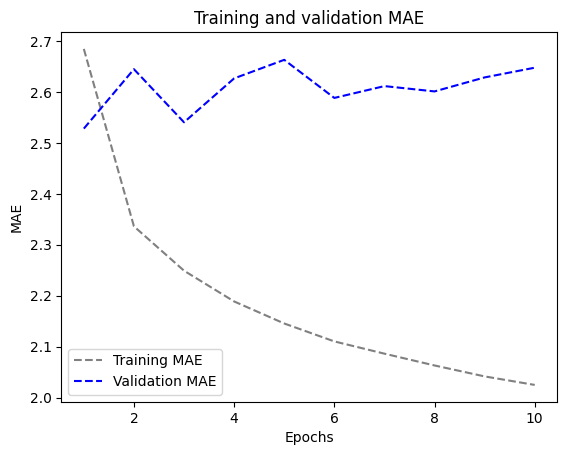

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 19ms/step - loss: 22.0793 - mae: 3.7006 - val_loss: 17.0999 - val_mae: 3.2718
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 15.4423 - mae: 3.1321 - val_loss: 15.4980 - val_mae: 3.1080
Epoch 3/10
819/819 [==============================] - 15s 19ms/step - loss: 14.1165 - mae: 2.9918 - val_loss: 19.9564 - val_mae: 3.5593
Epoch 4/10
819/819 [==============================] - 15s 19ms/step - loss: 13.2407 - mae: 2.8964 - val_loss: 19.5783 - val_mae: 3.5354
Epoch 5/10
819/819 [==============================] - 15s 19ms/step - loss: 12.5007 - mae: 2.8113 - val_loss: 15.7867 - val_mae: 3.1409
Epoch 6/10
819/819 [==============================] - 15s 19ms/step - loss: 11.7820 - mae: 2.7266 - val_loss: 15.1493 - val_mae: 3.0993
Epoch 7/10
819/819 [==============================] - 15s 19ms/step - loss: 11.2848 - mae: 2.6653 - val_loss: 17.0890 - val_mae: 3.2641
Epoch 8/10
819/819 [============================

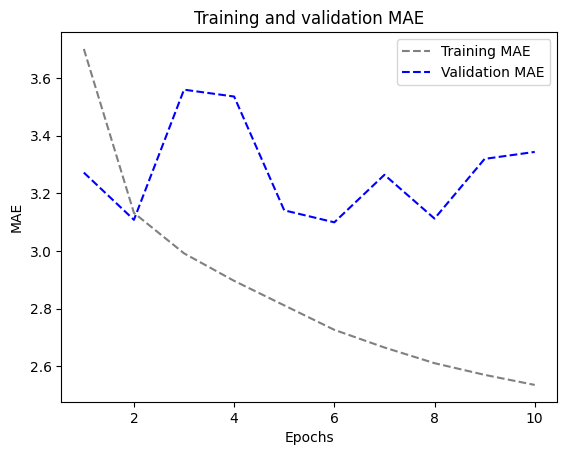

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*It seem that the convolutional data perform worse compared to common sense or dense model. it could be because*

*- The assumption of translation invariance does not hold well for weather data.*

*- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.*






## **A Simple RNN**

### **1.An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 54s 65ms/step - loss: 139.3956 - mae: 9.7107 - val_loss: 143.9525 - val_mae: 9.8908
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 136.4089 - mae: 9.5597 - val_loss: 143.8205 - val_mae: 9.8864
Epoch 3/10
819/819 [==============================] - 52s 64ms/step - loss: 136.3110 - mae: 9.5517 - val_loss: 143.6634 - val_mae: 9.8630
Epoch 4/10
819/819 [==============================] - 52s 63ms/step - loss: 136.2414 - mae: 9.5467 - val_loss: 143.6552 - val_mae: 9.8636
Epoch 5/10
819/819 [==============================] - 52s 64ms/step - loss: 136.1721 - mae: 9.5391 - val_loss: 143.6233 - val_mae: 9.8610
Epoch 6/10
819/819 [==============================] - 52s 64ms/step - loss: 136.1451 - mae: 9.5372 - val_loss: 143.6001 - val_mae: 9.8587
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 136.1175 - mae: 9.5334 - val_loss: 143.5383 - val_mae: 9.8517
Epoch 8/10
819/819 [==============

### **2.Simple RNN - Stacking RNN layers**

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 60s 70ms/step - loss: 137.0348 - mae: 9.5790 - val_loss: 143.4262 - val_mae: 9.8360
Epoch 2/10
819/819 [==============================] - 58s 70ms/step - loss: 135.9945 - mae: 9.5182 - val_loss: 143.4348 - val_mae: 9.8386
Epoch 3/10
819/819 [==============================] - 59s 72ms/step - loss: 135.9241 - mae: 9.5087 - val_loss: 143.4128 - val_mae: 9.8348
Epoch 4/10
819/819 [==============================] - 58s 70ms/step - loss: 135.8854 - mae: 9.5020 - val_loss: 143.4107 - val_mae: 9.8340
Epoch 5/10
819/819 [==============================] - 58s 71ms/step - loss: 135.8511 - mae: 9.4968 - val_loss: 143.4445 - val_mae: 9.8409
Epoch 6/10
819/819 [==============================] - 57s 70ms/step - loss: 135.8366 - mae: 9.4945 - val_loss: 143.4270 - val_mae: 9.8369
Epoch 7/10
819/819 [==============================] - 57s 70ms/step - loss: 135.8257 - mae: 9.4926 - val_loss: 143.4270 - val_mae: 9.8398
Epoch 8/10
819/819 [==============

### **Simple LSTM(Long Short-Term Memory )**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 43s 50ms/step - loss: 40.6847 - mae: 4.6409 - val_loss: 13.2458 - val_mae: 2.7118
Epoch 2/10
819/819 [==============================] - 41s 49ms/step - loss: 11.0557 - mae: 2.5794 - val_loss: 9.5420 - val_mae: 2.4052
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 10.0023 - mae: 2.4610 - val_loss: 9.2341 - val_mae: 2.3626
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 9.6118 - mae: 2.4114 - val_loss: 9.1983 - val_mae: 2.3624
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 9.3057 - mae: 2.3705 - val_loss: 9.5570 - val_mae: 2.4049
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 9.0564 - mae: 2.3391 - val_loss: 10.1021 - val_mae: 2.4370
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 8.8156 - mae: 2.3070 - val_loss: 10.6736 - val_mae: 2.4897
Epoch 8/10
819/819 [==============================] - 41

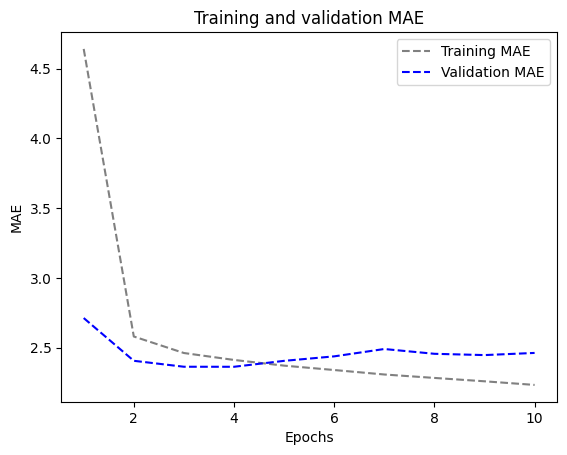

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **A Simple GRU (Gated Recurrent Unit)**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 41s 48ms/step - loss: 42.6731 - mae: 4.7490 - val_loss: 13.1668 - val_mae: 2.7281
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 10.5746 - mae: 2.5321 - val_loss: 9.1370 - val_mae: 2.3475
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 9.4560 - mae: 2.4035 - val_loss: 9.2436 - val_mae: 2.3557
Epoch 4/10
819/819 [==============================] - 39s 48ms/step - loss: 9.1412 - mae: 2.3607 - val_loss: 9.6983 - val_mae: 2.4008
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 8.9362 - mae: 2.3348 - val_loss: 9.4020 - val_mae: 2.3734
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 8.7669 - mae: 2.3143 - val_loss: 9.4151 - val_mae: 2.3754
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 8.6135 - mae: 2.2956 - val_loss: 9.2729 - val_mae: 2.3586
Epoch 8/10
819/819 [==============================] - 39s 4

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **LSTM - dropout Regularization**

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 58s 68ms/step - loss: 51.9557 - mae: 5.3920 - val_loss: 14.5824 - val_mae: 2.8799
Epoch 2/50
819/819 [==============================] - 56s 69ms/step - loss: 20.3035 - mae: 3.4627 - val_loss: 9.8946 - val_mae: 2.4399
Epoch 3/50
819/819 [==============================] - 56s 68ms/step - loss: 18.3122 - mae: 3.2885 - val_loss: 9.4274 - val_mae: 2.3903
Epoch 4/50
819/819 [==============================] - 56s 68ms/step - loss: 17.3985 - mae: 3.2088 - val_loss: 9.1875 - val_mae: 2.3587
Epoch 5/50
819/819 [==============================] - 56s 68ms/step - loss: 16.8289 - mae: 3.1559 - val_loss: 9.0415 - val_mae: 2.3462
Epoch 6/50
819/819 [==============================] - 56s 68ms/step - loss: 16.2663 - mae: 3.1013 - val_loss: 9.2397 - val_mae: 2.3611
Epoch 7/50
819/819 [==============================] - 56s 68ms/step - loss: 15.7864 - mae: 3.0596 - val_loss: 9.0812 - val_mae: 2.3408
Epoch 8/50
819/819 [==============================] - 

In [ ]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **LSTM - Stacked setup**

**Training and evaluating a stacked with 16 unit LSTM model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16, return_sequences=True)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Training and evaluating a stacked with 32 unit LSTM model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Training and evaluating a stacked with 8 unit LSTM model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8, return_sequences=True)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Training and evaluating a dropout-regularized, stacked LSTM model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Training and evaluating Bidirectional LSTM**

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()